# Scrape Facebook Like a Boss with ```Selenium``` & ```BeautifulSoup```

<div align="center">
    <img src='./images/1.png' width=1000>   <!-- Markdown doesn't allow centering of images :( -->
</div>

Social media sites are... _way harder_ to scrape than your average ```Selenium``` and ```BeautifulSoup``` tutorials. Don't get me wrong, those tutorials brought hours and hours of fun and joy and braingasms and ecstasies for me, so they are immensely useful - especially if you like to stare at data for hours. 😵😵😵😵

### Before you proceed:

Scraping Facebook is _not exactly legal_. So do this at your own risk.

# Step 0. Preamble

<div align="center">
    <img src='./images/pexels-lovefood-art-1437590.jpg' height=600>   <!-- Markdown doesn't allow centering of images :( -->
    <h6>Credit: <a href=https://www.pexels.com/photo/shrimp-soup-in-white-ceramic-bowl-with-chili-on-brown-wooden-surface-1437590/>Lovefood Art on Pexels</a></h6>
</div>

Look, no humans can resist spicy, sweet gallangal, kaffir lime and leaves packed into a bowl of thick Tom Yam Goong broth exploding in your mouth. But the pandemic means you can't travel to Bangkok or Hatyai to fill your belly with Pad Gaprao, Moo Ping, Tom Yam Goong, Khao Kha Moo, Som Tam......

So you decided to open up a Thai food business, to serve the market full of raging, hungry Thai food lovers (which means _practically everybody_).

You decided to do some research on social media, and you found a popular Facebook Group: [Authentic Thai Cooking](https://www.facebook.com/groups/authenticthaicooking).

Within a few minutes, you are swarmed with all the tasty looking pictures. You are even more confused - what items should you include in your new restaurant menu? How spicy your Tom Yam Goong should be? All these questions only means you need a data oriented approach.

As a start, you decided to harvest all the posts that the nice folks in the group writes, and do exploratory data analysis.

### Here's the game plan...

Before you fire up your code editor to write code, hold your ~~Tom Yams~~ horses. Here's the game plan:

<div align="center">
    <img src='./images/2.png' width=1000>   <!-- Markdown doesn't allow centering of images :( -->
</div>

Alright, sounds like a plan. Let's do this!

# Step 1. Let's log in Facebook

Finally, some code.

In [1]:
# import the necessary libraries
from selenium import webdriver                        # to run the browser window
from selenium.webdriver.common.keys import Keys       # to send keys to the login screen
from selenium.webdriver.chrome.options import Options # set options to avoid annoying behaviours
from bs4 import BeautifulSoup                         # to parse the html

import time                                           # for creating random delays among requests
import numpy as np

In [2]:
# the following Options setting code prevents the annoying "https://www.facebook.com wants to 
# Show Notifications" dialog box from showing.
# Credit: https://stackoverflow.com/questions/38684175/how-to-click-allow-on-show-notifications-popup-using-selenium-webdriver
option = Options()

option.add_argument("--disable-infobars")
option.add_argument("start-maximized")
option.add_argument("--disable-extensions")

# Pass the argument 1 to allow and 2 to block
option.add_experimental_option("prefs", { 
    "profile.default_content_setting_values.notifications": 1
})

# you may download ChromeDriver from https://chromedriver.chromium.org/
chrome_driver_path = r'G:\ChromeDriver\chromedriver.exe'     # point to your path
driver = webdriver.Chrome(chrome_driver_path, options=option)

In [3]:
driver.get('https://www.facebook.com')                # ask the browser to goto FB

In [4]:
email_addr = 'youremail@youremail.com'                # your email
pwd = 'yourfacebookpassword12345'                     # your password

In [5]:
email_id_elem = driver.find_element_by_id('email')    # find the email address text box

In [6]:
email_id_elem.send_keys(email_addr)                   # you should see your email appearing in text box
                                                      # yeah, I know. It's like magic

In [7]:
password_elem = driver.find_element_by_id('pass')     # find the password field... and...
password_elem.send_keys(pwd)                          # fire the password to the field

In [8]:
login_btn_elem = driver.find_element_by_name('login') # to login, find the login button... and...
login_btn_elem.click()                                # click. That's it. It's magical, aint it.

time.sleep(5)                                         # give it some time to log in...

# Step 2. The FUN part begins!

By now, you should have logged in Facebook successfully in the Chrome Driver window.

This is the part where we:

1. Go to the Authentic Thai Cooking group URL: https://www.facebook.com/groups/authenticthaicooking
2. Scroll down until your mouse scroll buttons breaks. (_Actually we will do this using code, no worries_)
3. Some longer posts are obscured by the "See More" links. We will click on all of them (_again, using code_) to make sure all of texts are displayed.

Ready?

In [9]:
# Step 2.1: Go to the Authentic Thai Cooking group

fb_group_url = 'https://www.facebook.com/groups/authenticthaicooking'
driver.get(fb_group_url)    # load up this group in the browser

In [10]:
# Step 2.2: Scroll down until your mouse scroll buttons breaks (using code though)

# The following code was modified from the great folks from Stack Overflow.
# Credit: https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python
last_height = driver.execute_script("return document.body.scrollHeight")        # Get scroll height

N = 10
for _ in range(N):                    # scroll down N times (change N to whatever you want, e.g. 100 times)
                                      # the original code used 'while True:', but I do not want to run
                                      # into the risk of infinite loops.

    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    SCROLL_PAUSE_TIME = np.random.uniform(1.0,3.0)
    time.sleep(SCROLL_PAUSE_TIME)                  # pause between 1-3 seconds

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

### Remember Step 2.3?

!["See More" links](./images/see_more_click.png)

We need to look for all annoying links with the "See More" texts, since there are obscuring the longer posts.

We need to ask our computer to find all of these "See More" links, and click on all of them.

But how do we find them? The answer is found when you right click on one of them, and select "Inspect Element".

![ag](./images/see_more.png)

Should be straight forward enough. We look for all ```<div>``` tags, that have ```role==button``` attributes. Then we click on them.

In [11]:
# Step 2.3: Some longer posts are obscured by the "See More" links. We will click on all of them

javascript_cmd = '''
    var elems = document.querySelectorAll('div[role="button"]');          // select all div's with 'role = button' attribute
    var see_more_btns = [...elems].filter(e => e.innerText == "See More") // filter down to "See More" buttons only
    see_more_btns.forEach(e => e.click());                                // click all of them!    
'''

driver.execute_script(javascript_cmd)   # click all of them!

## What? Javascript?!

I know, I know. I lied when I implied we will be using Python only.

This deserves some explanation.

In theory, you should be able to click on those links programmatically by interfacing Python and Selenium. I tried that - doesn't work. I think it is Chromium Selenium driver bug, but there is nothing much I can do.

Basically, the ```driver.execute_script()``` function does what it says: if you feedback Javascript code into it, it will run the Javascript code.

After cobbling up some poorly written JS in Chrome's JS console, I found a way to select all those links, and click on them. 

Problem solved. But please pardon my poor JS skills though. 🙂

Let's move on to Step 3!

# Step 3: Find all the delicious posts, and harvest the posts' texts

Next, with all the posts/data we need loaded in the HTML, we can use ```BeautifulSoup``` to parse the HTML tags. (_We could have used Selenium's functions, but I find using ```BeautifulSoup``` easier_)

In [12]:
page_html = driver.page_source    # get the page source/HTML
page_html[:100]                   # display first 100 chars, for sense checking

'<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" id="facebook" class="_9dls __fb-dark-mode"'

In [13]:
soup = BeautifulSoup(page_html, 'lxml')    # we could have used 'html.parser', but 'lxml' is reportedly way faster

Next, we need to understand how FB structures their HTML code. Otherwise we will have a hard time harvesting the posts' texts

Again, our best friend here is Chrome's Javascript console (just press F12 on your browser window).

To cut a looooooong story short, I found out FB structures their HTML (roughly) this way:

<div align="center">
    <img src='./images/3.png' width=1000>   <!-- Markdown doesn't allow centering of images :( -->
</div>

Now that we know how (a little) about how the HTML document is structured, it seems to be fairly easy to find the posts' texts.

1. Find the 'Page Feed' element.
2. Under the 'Page Feed' element, find all the 'Article' elements.
3. Under each 'Article' element, find the post texts buried deep in there.

Simple enough?

In [14]:
feed_elem = soup.find('div', {'role':'feed'})    # find the posts feed (all articles/posts are under it)

In [15]:
article_elems = feed_elem.find_all('div', {'role':'article'})  # find all articles/posts
len(article_elems)

100

In [23]:
all_posts = []    # list to hold all the posts' texts

for i, article in enumerate(article_elems):
    
    # dir="auto" style="text-align: start;"
    div_xpath = r".//div[contains(@dir,'auto')]"
    divs = article.find_all('div', {'dir':'auto', 'style':'text-align: start;'})
    
    post_text = ' '.join([div.text for div in divs])   # the post text, joined.
    all_posts.append(post_text)
    
    if post_text and i < 10:                           # print out the first 10 posts texts, for your viewing pleasure
        print(f'-----[ Post # {i+1:3d} ]-----')
        print(post_text + '\n')

-----[ Post #   1 ]-----
Shiitake, Oyster & King Oyster Mushrooms w/ Crispy Noodle for dinner. #homemadefoodswithlove #itsallaboutmushrooms I followed Marion Grasby; https://m.youtube.com/watch?v=CJbkoeQbxUY mmmm crunchy noodles soaked with mushroom sauce!

-----[ Post #   2 ]-----
mmmm crunchy noodles soaked with mushroom sauce!

-----[ Post #   4 ]-----
I don't know if you guys keep up with the new trend but these fried Thai Chili Peppers have become a super hot trend n in high demand!  I didn't want to buy them for a hefty price anymore so I decided to make them myself!!!  IT IS A LOT OF WORK... VERY TEDIOUS N TIME CONSUMING!!!  OMG...BUT THEY'RE SO YUMMY FOR SNACKING!!! I love it. Would be nice if it was a little spicy. It’s not spicy but very flavorful.  Recipe please

-----[ Post #   5 ]-----
I love it. Would be nice if it was a little spicy. It’s not spicy but very flavorful. 

-----[ Post #   6 ]-----
Recipe please

-----[ Post #   7 ]-----
Who wants to salivate?… Thai tamarind

### We are almost done!

So we have all the post texts stored in the ```all_posts``` list.

But as good programmers, we always clean up unused resources.

In [17]:
# clean up
driver.close()
driver.quit()

# Step 4. You have the data... So...

There are so many possible things you can do with the data. For example, doing Natural Language Processing stuffs.

Here is an example below, thanks to the good folks at [Parallel Dots](https://www.paralleldots.com/text-analysis-apis). Do play with their demo, and try out the free API tier.

![Parallel Dots Demo](./images/parallel_dots_demo.png)

If you don't want to deal with API's, I also included some quick examples of simple Sentiment Analysis, using the ```TextBlob``` package.

In [24]:
from textblob import TextBlob

In [25]:
sentiments = []

for post in all_posts:
    blob = TextBlob(post)
    sentiments.append(blob.sentiment.polarity)

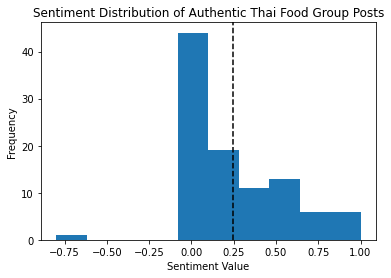

In [26]:
import matplotlib.pyplot as plt        # for making beautiful graphs

plt.hist(sentiments, bins=10)          # show the sentiment dist via histogram
plt.axvline(np.mean(sentiments),       # show the average sentiment value
            color='black',
            linestyle='--')   
plt.title('Sentiment Distribution of Authentic Thai Food Group Posts')
plt.ylabel('Frequency')
plt.xlabel('Sentiment Value');

Don't we all love ```Matplotlib```?

Well, if you want to try play mind voodoo tricks on your boss, try ```Matplotlib``` with xkcd style!

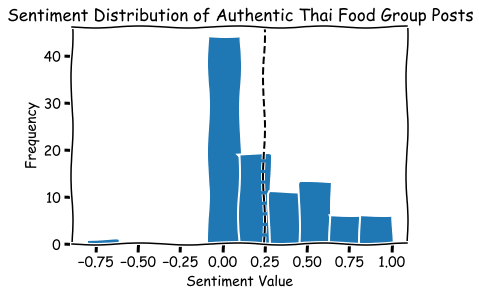

In [28]:
with plt.xkcd():                       # don't do the XKCD style at work!
    plt.hist(sentiments, bins=10)      # show the sentiment dist via histogram
    plt.axvline(np.mean(sentiments),   # show the average sentiment value
                color='black',
                linestyle='--')   
    plt.title('Sentiment Distribution of Authentic Thai Food Group Posts')
    plt.ylabel('Frequency')
    plt.xlabel('Sentiment Value');

In [29]:
percent_positive = np.mean(np.array(sentiments) > 0)

print(f'{percent_positive:.1%} of posts were having positive sentiments.')

61.0% of posts were having positive sentiments.


# Thanks for Reading!

With a few lines of code, we now understand better the sentiment distribution of the group's posts.

If you like this tutorial, please share it with a friend. 😀

As I mentioned earlier, there are tonnes of interesting stuffs we can do with these data. There are so much insights in text data that I feel are underutilized even nowadays. Let's change that.

But that will be material for a separate tutorial. 😀

See ya 😀